# Esercitazioni
In questo quaderno proviamo a mettere in atto insieme quanto abbiamo appreso per costruire uno spettro ed effettuare una calibrazione. Questa parte in particolare vi sarà richiesto di farla durante l'attività di spettroscopia gamma, quindi può essere utile avere un'idea di come approciare il problema ed avere qualcosa di già pronto all'uso :)

Come al solito, l'analisi verrà effettuata col pitone.

## Step 0: import dei moduli necessari

Iniziamo caricando i moduli necessari: non preoccupatevi se ve ne scordate qualcuno che vi servirà in seguito, si può sempre tornare qui ad aggiungerla oppure caricarla laddove ci serve. Per mantenere il codice più ordinato, può essere buona norma caricarle qui.

In [1]:
# Codice per caricare i moduli necessari

import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit


# Questa variabile può essere comoda per decidere se salvare o meno i plot che si vanno a creare
Export = False

# Per avere i plot "in linea", sotto le celle
%matplotlib inline

## Step 1: load dei dati

I dati che da utilizzare sono contenuti nel file [`run020752.dat`](https://scarsi.web.cern.ch/INSULAB/LAB4/run020752.dat): si tratta di un file ASCII (che vi lascio l'onore di aprire da soli) costituito da 5 colonne: la prima contiene il tempo UNIX, mentre le altre 4 il valore del massimo della waveform riferito a 4 diversi canali. Voi dovrete utilizzare i dati provenienti dal primo canale, ovvero contenuti nella colonna...?

In [2]:
# Codice per caricare i dati

dati = np.loadtxt("run020752.dat")

# un'altra possibilità, considerato che ci serve solamente la seconda colonna, sarebbe potuta essere
#_, datiVect, _, _, _ = np.loadtxt("run020752.dat", unpack = True)

In [3]:
# Codice per visualizzare schematicamente informazioni sui dati

print(dati.shape, dati)


(200001, 5) [[1.48006496e+09 5.91000000e+02 8.70000000e+01 6.60000000e+01
  1.06000000e+02]
 [1.48006496e+09 1.30000000e+02 6.00000000e+00 4.09500000e+03
  6.90000000e+01]
 [1.48006496e+09 2.35000000e+02 9.20000000e+01 6.60000000e+01
  1.06000000e+02]
 ...
 [1.48006518e+09 1.25800000e+03 8.50000000e+01 6.70000000e+01
  1.07000000e+02]
 [1.48006518e+09 2.75000000e+02 8.70000000e+01 6.50000000e+01
  1.06000000e+02]
 [1.48006518e+09 1.75300000e+03 8.60000000e+01 6.80000000e+01
  1.07000000e+02]]


## Step 2: costruzione e visualizzazione dell'istogramma

Come abbiamo visto, a noi interessa la distribuzione di questi valori: procediamo quindi alla costruzione di un istogramma ed alla sua visualizzazione. L'ADC, ovvero lo strumento che campiona la forma d'onda ha una risoluzione a 12 bit, quindi il maggior numero che ci può restituire è $2^{12}=$..? Casomai comparissero valori più elevati, che si fa?

In [4]:
# Codice per costruire l'istogramma

h, bins = np.histogram(dati[:,1], bins = 1000)

binc = bins[:-1] + (bins[1] - bins[0])/2

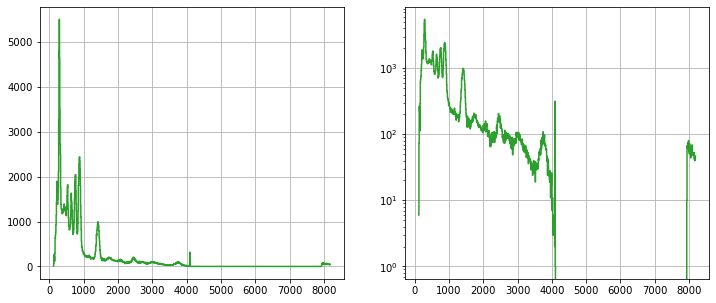

In [5]:
# Alcune prove sbagliate, comode da avere
"""
Notiamo in particolare l'importanza di guardare il grafico con asse y logaritmico 
e di effettuare un taglio sul valore massimo: l'ADC può avere come valore massimo
4096 (è a 12 bit ==> Nmax = 2^12 = 4096, tutti i valori al di sopra di tale soglia 
non hanno significato fisico, sono fluttuazioni o saturazione
"""


fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,5)
ax[0].plot(binc, h, ds = "steps-mid", c = "tab:green" )
ax[1].plot(binc, h, ds = "steps-mid", c = "tab:green" )

ax[1].set_yscale("log")

for i in ax:
    i.grid(True)


plt.show()

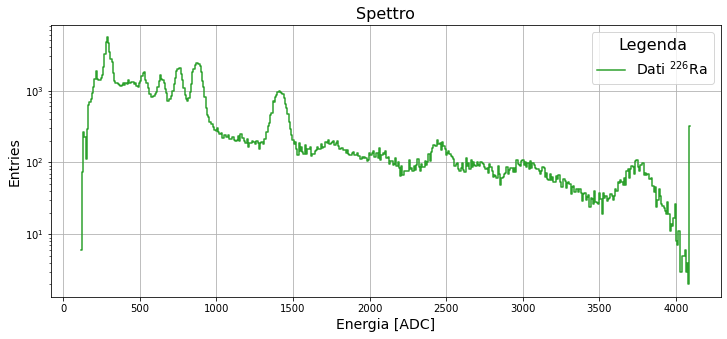

In [6]:
# Codice per visualizzare l'istogramma

cond = binc<4096

fig, ax = plt.subplots()
fig.set_size_inches(12,5)

ax.plot(binc[cond], h[cond], ds = "steps-mid", c = "tab:green", label = "Dati $^{226}$Ra" )

ax.set_title("Spettro", fontsize = 16)
ax.set_xlabel("Energia [ADC]", fontsize = 14)
ax.set_ylabel("Entries", fontsize = 14)

ax.grid(True)
ax.set_yscale("log")
ax.legend(fontsize = 14, title = "Legenda", loc = "upper right", title_fontproperties = {"size":16})

plt.show()


Una riflessione finale:
Abbiamo fatto il taglio sull'istogramma già costruito, in poche parole visualizziamo solamente una porzione
dell'istogramma costruito. Poiché ci sono fondati motivi teorici per fissare un limite massimo, sarebbe buona
norma mettere il range sull'istogramma da costruire.
In questo esempio ho aggirato il problema facendo mooolti bin

### Versione corretta

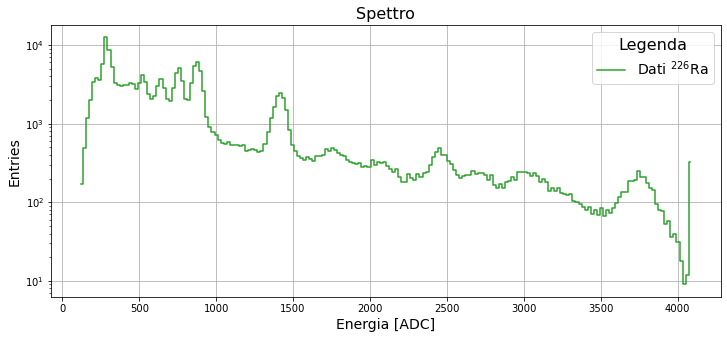

In [7]:
DATI = dati[:,1][dati[:,1] < 4096]

h, bins = np.histogram(DATI, bins = 200)

binc = bins[:-1] + (bins[1] - bins[0])/2


fig, ax = plt.subplots()
fig.set_size_inches(12,5)

ax.plot(binc, h, ds = "steps-mid", c = "tab:green", label = "Dati $^{226}$Ra" )

ax.set_title("Spettro", fontsize = 16)
ax.set_xlabel("Energia [ADC]", fontsize = 14)
ax.set_ylabel("Entries", fontsize = 14)

ax.grid(True)
ax.set_yscale("log")
ax.legend(fontsize = 14, title = "Legenda", loc = "upper right", title_fontproperties = {"size":16})

plt.show()

## Step 3: fit dei picchi

Una volta costruito l'istogramma, vogliamo effettuare il fit dei picchi: in particolare vogliamo trovare la $x$ del massimo e il corrispondente errore: effettuiamo quindi il fit con una funzione...?

Notare in particolare come i picchi non siano centrati sullo 0 ma abbiano un offset verticale: sarà opportuno tenerne conto. Se il passaggio precedente è stato effettuato correttamente può sembrare che siano montati su una retta decrescente: attenzione a non farsi ingannare dalle impostazioni degli assi

I picchi da fittare sono i primi 7, che hanno energie 77, 185, 241, 295, 351, 609 e 1120 keV. (Il secondo picco nell'immagine sottostante compare a 186/187, nel logbook fornito era dato a 185. In ogni caso non fa tutta sta gran differenza...)

![](./226Ra.jpg)

Si tratta di fit un po' delicati da far convergere, serve un po' di pazienza: per aiutarsi a stimare gli starting points può essere utile ricorrere al seguente magic command `%matplotlib qt` che consente di aprire il plot in una finestra grafica esterna, e dove muovendosi col puntatore si possono visualizzare le coordinate. Per visualizzare i plot nel modo usuale, esiste il magic command `%matplotlib inline`. 

In [8]:
# Definiamo la funzione di fit

"""
Quando si guarda un plot ylog, gli esponenziali vengono trasformati in rette: per tener conto del 
fondo che decresce linearmente, sommiamo alla gaussiana del picco un esponenziale decrescente
"""

def funcToFit(x, a, mu, sigma, b, c):
    return (a/(sigma * np.sqrt(2*np.pi)) * np.exp(-(x-mu)**2 / (2*sigma**2))) + (b * np.exp(-c*x))

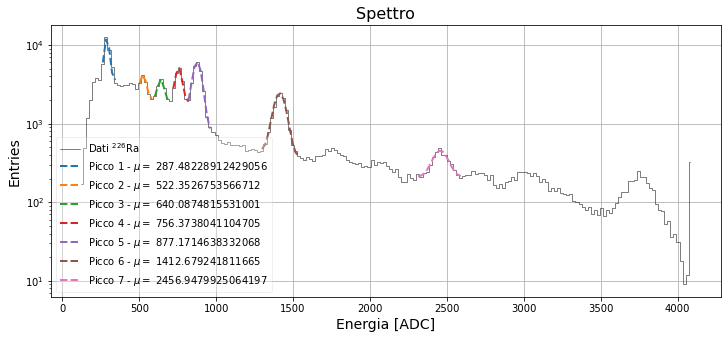

In [9]:
# Codice per fare i fit

# Utile se vogliamo visualizare in una finestra i picchi per stimare i punti
# %matplotlib qt


# ---------0 ----------1 -----------2 ----------3 ----------4 ----------5 -------------6 -------
energieVere = np.array((77, 185, 241, 295, 351, 609, 1120))

# Alcuni parametri per il fit
myRange = ((260, 358), (492, 590), (590, 704), (704, 825), (806, 971), (1296, 1556), (2305, 2600))
startPars = ((3.14020187e+05, 2.98589322e+02, 1.43257226e+01),
             (9.41411082e+04, 5.34214983e+02, 2.02581202e+01),
             (1.04459955e+05, 6.51821651e+02, 2.23514168e+01),
             (2.30961972e+05, 7.65474019e+02, 2.49634128e+01),
             (3.65195534e+05, 8.86502718e+02, 2.82249031e+01),
             (.215e5, 1422, 41.2),
             (9.82593192e+04, 2.47588684e+03, 1.06711679e+02),)

# Inizializzo due liste in cui vado a memorizzare i parametri estratti dal fit
lstPopt = []
lstPcov = []
           
  
# Definisco una funzione comoda per poter raggruppare le stesse operazioni da effettuare varie volte
def myFun(axx, idx):
    
    # Seleziono il range in cui fare il fit
    tmpCond = (binc > myRange[idx][0]) & (binc < myRange[idx][1])
    
    # Definisco gli starting points
    tmpp0 = (*startPars[idx], 7.81582354e+03, 2.32745796e-03)
    
    # Effettuo il fit
    popt, pcov = curve_fit(funcToFit, binc[tmpCond], h[tmpCond], p0 = tmpp0, 
                           sigma = np.sqrt(h[tmpCond]), absolute_sigma = True)
    
    # Memorizzo i parametri
    lstPopt.append(popt)
    lstPcov.append(pcov)
          
        
    # Plotto le curve fittate    
    #axx.plot(binc[tmpCond], funcToFit(binc[tmpCond], *tmpp0), ls = ":", c = "r")
    axx.plot(binc[tmpCond], funcToFit(binc[tmpCond], *popt), ls = "--", lw = 2,
             label = f"Picco {idx+1} - $\mu=$ {popt[1]}")
            
           

            
# Rifaccio il plot dell'istogramma definito nella cella precedente
fig, ax = plt.subplots()
fig.set_size_inches(12,5)

ax.plot(binc, h, ds = "steps-mid", c = "k", label = "Dati $^{226}$Ra", lw= .5 )


                           
# Vao a richiamare la funzione per ciascun picco  
for i in range(7): myFun(ax, i)                          
                           
                           
# Alcune impostazioni grafiche del plot                           
ax.set_title("Spettro", fontsize = 16)
ax.set_xlabel("Energia [ADC]", fontsize = 14)
ax.set_ylabel("Entries", fontsize = 14)

ax.grid(True)
ax.set_yscale("log")
ax.legend(fontsize = 10, framealpha = .3)

plt.show()

## Step 4: ottenimento dei valori estratti dal fit

Dopo aver effettuato il fit è importante ottenere i parametri risultanti dal fit, in particolare ci interessa ottenere $\mu$ e $\sigma$ delle gaussiane con i relativi errori. I parametri si trovano direttamente in `popt`, mentre `pcov` costituisce la matrice delle covarianze. Sulla diagonale si trovano le varianze, ovvero il quadrato dell'incertezza.

Inoltre, essendo la gaussiana $$\dfrac{1}{\sigma\,\sqrt{2\pi}}\,e^{-\dfrac{(x-\mu)^2}{2\sigma^2}}$$
normalizzata, ovvero di area unitaria, il prefattore $a$ rappresenta l'area della gaussiana.

In [10]:
# Codice per ottenere parametri ed errori

"""
Per ottenerli, trattandosi di solo 7 elementi, posso ciclare. Per compattezza
ho scelto di utilizzare una list comprehension, ovvero una sorta di ciclo for
compatto. Uno avrebbe tranquillamente potuto impostare un ciclo for standard.
"""

lstMu = np.array([i[1] for i in lstPopt])
lstSigma = np.array([i[2] for i in lstPopt])
lstErrMu = np.array([np.sqrt(np.diag(i))[1] for i in lstPcov])
lstErrSigma = np.array([np.sqrt(np.diag(i))[2] for i in lstPcov])

lstArea = np.array([i[0] for i in lstPopt])
lstErrArea = np.array([np.sqrt(np.diag(i))[0] for i in lstPcov])

# Stampo un esempio di tabella latex
for i in range(7):
    print(f"Picco {i+1}\t& Mu: {lstMu[i]:.2f}±{lstErrMu[i]:.2f}\t& Sigma: {lstSigma[i]:.2f}±{lstErrSigma[i]:.2f}\t& Area: {lstArea[i]:.2f}±{lstErrArea[i]:.2f} \\\\")

Picco 1	& Mu: 287.48±5643.73	& Sigma: 17.62±10310.91	& Area: 418698.42±498368222.01 \\
Picco 2	& Mu: 522.35±560015.00	& Sigma: 21.24±748404.13	& Area: 123272.27±11156549853.01 \\
Picco 3	& Mu: 640.09±0.86	& Sigma: 18.38±1.11	& Area: 76587.31±6160.32 \\
Picco 4	& Mu: 756.37±0.65	& Sigma: 18.90±0.85	& Area: 143121.94±9088.29 \\
Picco 5	& Mu: 877.17±0.44	& Sigma: 27.89±0.52	& Area: 353261.16±8602.73 \\
Picco 6	& Mu: 1412.68±0.60	& Sigma: 38.18±0.66	& Area: 193796.80±3716.40 \\
Picco 7	& Mu: 2456.95±2.97	& Sigma: 47.31±3.64	& Area: 28795.52±2729.95 \\


## Step 5: costruzione della retta di calibrazione

A questo punto, sapendo i valori dei picchi in ADC e la corrispondente energia vera, possiamo costruire la **retta di calibrazione**. Per stabilire chi mettere sulle $x$ e chi sulle $y$ chiediamoci chi ha errore e chi assumiamo come esatto. Ricordiamoci inoltre che la retta di calibrazione consente di passare da ADC a keV.

In [11]:
# Codice per fittare la retta di calibrazione

# Definisco la funzione di fit
def line(x, m, q):
    return m*x+q

# Effettuo il fit
popt, pcov = curve_fit(line, energieVere, lstMu, sigma = lstSigma, absolute_sigma = True)

# Calcolo il chi2
chi2 = np.sum( ( (line(energieVere, *popt) - lstMu ) / lstSigma)**2 ) / (len(lstMu) - 2)
print(f"Il chi2 ridotto vale {chi2}")

Il chi2 ridotto vale 0.11426215202094855


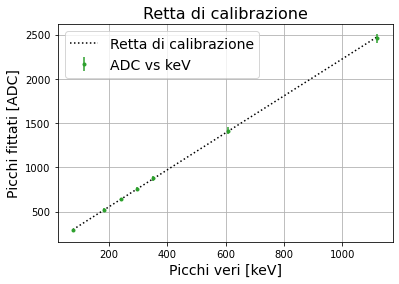

In [12]:
# Codice per plottare la retta di calibrazione

fig, ax = plt.subplots()

ax.errorbar(energieVere, lstMu, yerr = lstSigma, c = "tab:green", marker = ".", ls = "", label = "ADC vs keV")
ax.plot(energieVere, line(energieVere, *popt), c = "k", ls = ":", label = "Retta di calibrazione")

ax.set_title("Retta di calibrazione", fontsize = 16)
ax.set_xlabel("Picchi veri [keV]", fontsize = 14)
ax.set_ylabel("Picchi fittati [ADC]", fontsize = 14)

ax.grid(True)
ax.legend(fontsize = 14)

plt.show()


## Step 6: plot dell'istogramma in energia

A questo punto per plottare l'istogramma in energia non ci resta che copiare il codice usato in precedenza, applicando *una certa trasformazione* alle $x$... per ottenere lo spettro della nostra sorgente di $^{226}$Ra.

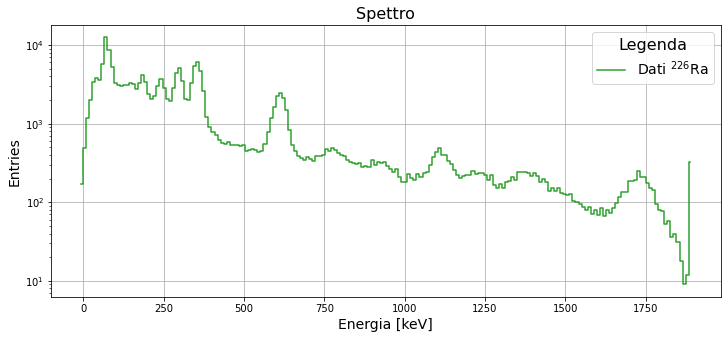

In [13]:
# Codice per plottare l'istogramma in energie

"""
Come già discusso, la retta di calibrazione è quella funzione che consente di passare da ADC a keV.
Quella appena costruita è l'inverso della retta di calibrazione. Fortunatamente le rette sono funzioni
invertibili

y = mx + q -> (y-q)/m = x

Il coefficiente ancolare diventa 1/m, mentre l'intercetta è -q/m
"""

m = 1/popt[0]
q = -popt[1]/popt[0]


# Copiando dallo step 2

h, bins = np.histogram(DATI, bins = 200)

binc = bins[:-1] + (bins[1] - bins[0])/2

# PASSAGGIO NUOVO: CONVERTO I BINC IN KEV
bincInKev = line(binc, m, q)


fig, ax = plt.subplots()
fig.set_size_inches(12,5)

ax.plot(bincInKev, h, ds = "steps-mid", c = "tab:green", label = "Dati $^{226}$Ra" )

ax.set_title("Spettro", fontsize = 16)
ax.set_xlabel("Energia [keV]", fontsize = 14)
ax.set_ylabel("Entries", fontsize = 14)

ax.grid(True)
ax.set_yscale("log")
ax.legend(fontsize = 14, title = "Legenda", loc = "upper right", title_fontproperties = {"size":16})

plt.show()



# Pro tip

Durante l'attività di spettroscopia gamma acquisirete un file per ogni sorgente: piuttosto che aprire ciascun file salvandosi i dati in differenti variabili, può essere comodo automatizzare la procedura. Per ogni evento vengono salvati due differenti files: uno ".dat" che contiene i dati e uno ".log" che contiene alcune informazioni sull'acquisizione.

In una certa cartella ho due sottocartelle:
- PITONE: contiene gli script python
- DATI: contiene i dati acquisiti
Per automatizzare il tutto potrebbe essere conveniente implementare qualcosa del tipo

```python
# Questa lista contiene le varie matrici di dati, ogni matrice è un file
listaMatrici = []
# Questa lista invece contiene 
listaNum = []

# Ciclo su tutti i files nella cartella dati, indietro di un livello ("..")
for e in os.scandir(r"..\DATI"):
    if e.name.split(".")[1] != "dat": continue

    tmp = np.loadtxt(e.path)
    listaMatrici.append(tmp.copy())
    listaNum.append(int(e.name.split(".")[0][-2:]))
    
zipIt = zip(listaNum, range(len(listaNum)))
# Questo dizionario accetta come input il numero di run (in realtà gli ultimi due numeri) e dà come output l'indice progressivo con cui è stato caricato. Non è automaticamente garantito che i dati vengano caricati in ordine alfabetico
myDict = dict(zipIt)
```

Attenzione! È fodnamentale appendere `tmp.copy()` e non semplicemente `tmp`: nel primo caso si appende un nuovo oggetto per ogni file, mentre nel secondo caso si appende sempre lo stesso oggetto (e quindi tutte le matrici sarebbero uguali all'ultimo file aperto). 

Per effettuare la procedura di analisi e fit, anziché costruire manualmente plot ed istogrammi per ciascuna sorgente, ho implementato una funzione la cui firma è
```python
def makeFit(numRun, sogliaMin, sogliaMax, startPars, rangeFit, valVero, sorgente,\
            fig, ax, primoPicco = True):
```
che può essere un utile spunto. Ognuno di voi sceglierà comunque la strategia che più ritiene opportuna. In particolare l'opzione `primoPicco` serve a tener conto di sorgenti che abbiano più picchi (come il caso del $^{226}$Ra che abbiamo visto in questa esercitazione.

# Correlazioni

Se qualcuno volesse divertirsi, utilizzando [questi dati](https://scarsi.web.cern.ch/INSULAB/LAB4/run020252.dat) si possono provare a studiare le correlazioni. I dati sono formattati esattamente come nel caso precedente, solo che vi sono due PMT, connessi ai primi due canali dell'ADC

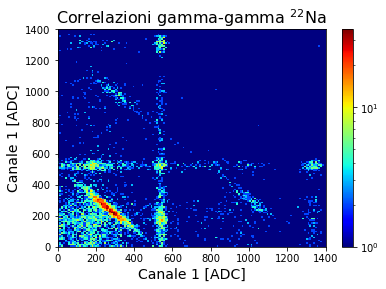

In [14]:
# Codice per visualizzare le correlazioni

import copy
import matplotlib as mpl


# Carico i dati
_, dati1, dati2, _, _ = np.loadtxt("run020252.dat", unpack = True)

# Converto in keV
dati1 = line(dati1, m, q)
dati2 = line(dati2, m, q)



# Costruisco e plotto l'istogramma
my_cmap = copy.copy(mpl.cm.jet) # copy the default cmap
my_cmap.set_bad(my_cmap(0))



fig, ax = plt.subplots()

myhist = ax.hist2d(dati1, dati2, bins = (150, 150), range = ((0, 1400), (0, 1400)),
          norm = mpl.colors.LogNorm(), cmap = my_cmap)

ax.set_title("Correlazioni gamma-gamma $^{22}$Na", fontsize = 16)
ax.set_xlabel("Canale 1 [ADC]", fontsize = 14)
ax.set_ylabel("Canale 1 [ADC]", fontsize = 14)

fig.colorbar(myhist[3], ax = ax)

plt.show()

Il significato di questo plot vi sarà sicuramente più chiaro dalla teoria vista a lezione e dall'esperienza relativa in laboratorio.
Senza la pretesa di essere esaustivo, dalla mia relazione:
<blockquote>
Si possono distinguere due bande verticali/orizzontali
in corrispondenza dei picchi fotoelettrici a 511 keV e 1274 keV: il primo
corrisponde al picco di annichilazione, mentre il secondo al fotone emesso dal
decadimento della sorgente. Non si nota un significativo addensamento in prossimità
dell’intersezione a 511 keV in quanto la sorgente era posta davanti ai
due rivelatori, mentre i due fotoni di annichilazione vengono emessi in direzioni
opposte: non risulta quindi possibile rivelare nei due rivelatori i due fotoni emessi
dall’annichilazione, e quando entrambi i rivelatori hanno rivelato un fotone da
511 keV non può che essere un evento casuale, dato dalla rivelazione di un fotone
ciascuno proveniente da due annichilazioni differenti.    
    
Le due bande diagonali rappresentano la situazione
in cui un fotone all’interno di un rivelatore ceda parte della sua energia per
effetto Compton e il fotone Compton, di bassa energia, ceda la rimanente energia
all’altro rivelatore: in questo caso tutta l’energia è stata ceduta, ma ai due
rivelatori vengono di volta in volta ceduti differenti valori.
    
Sotto la diagonale a 511 keV si può ben distinguere il Compton continuum.
Si osservi in particolare come le bande diagonali non raggiungano mai gli assi:
questo si verifica poiché il massimo trasferimento di energia mediante effetto
Compton non coincide col picco fotoelettrico, ed infatti negli spettri la spalla
Compton si trova sempre prima del corrispondente picco fotoelettrico.
</blockquote>

